In [80]:
from IPython.core.debugger import set_trace

%load_ext nb_black

# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pathlib import Path

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

np.random.seed(42)
tf.random.set_seed(42)

plt.style.use(style="seaborn")
%matplotlib inline

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [81]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


<IPython.core.display.Javascript object>

In [82]:
!nvidia-smi

Mon Jul  4 20:40:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P8    18W / 200W |   3252MiB /  4096MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<IPython.core.display.Javascript object>

In [83]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/MSFT/MSFT_WITH_TWINT_FINBERT_SA.csv"

<IPython.core.display.Javascript object>

In [84]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df.pop('date'))
# title = df.pop('tweet')

df = df[["5. adjusted close"]] 
# df = df[["2. high", "3. low", "5. adjusted close", "6. volume"]]

df.index = date_time

<IPython.core.display.Javascript object>

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   5. adjusted close  3064 non-null   float64
dtypes: float64(1)
memory usage: 47.9 KB


<IPython.core.display.Javascript object>

In [86]:
#df.set_index("date", drop=True, inplace=True)
df.head()

,5. adjusted close
date,
2010-01-04,23.857347
2010-01-05,23.865055
2010-01-06,23.718596
2010-01-07,23.473471
2010-01-08,23.633805


<IPython.core.display.Javascript object>

We'll use only the close feature.

In [87]:
# df = df[["close"]]

<IPython.core.display.Javascript object>

In [88]:
type(df["5. adjusted close"]) == type(df[["5. adjusted close"]])

False

<IPython.core.display.Javascript object>

In [89]:
type(df[["5. adjusted close"]])

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>

In [90]:
df.describe()

,5. adjusted close
count,3064.000000
mean,84.711218
std,81.182964
min,17.899248
25%,25.351937
50%,47.272908
75%,108.891906
max,342.401190


<IPython.core.display.Javascript object>

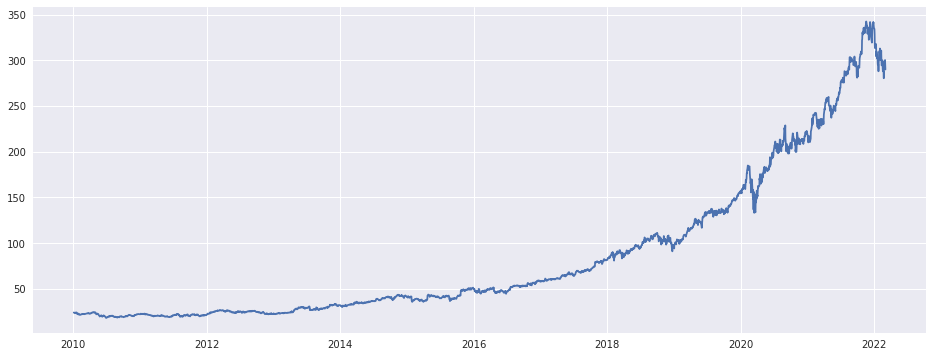

<IPython.core.display.Javascript object>

In [91]:
plt.figure(1, figsize=(16, 6))
_ = plt.plot(df['5. adjusted close'])

Calculate the percentage change.

The reason for using pct_change instead of the prices is the benefit of normalization as we can measure all variables in a comparable metric. Also returns have more manageable statistical properties than prices such as stationarity, as in most cases we don't have stationary prices but we can have stationary returns.

A stationary time series is one where statistical properties such as mean, variance, correlation, etc are constant over time.
For more details on stationarity: https://en.wikipedia.org/wiki/Stationary_process

In [92]:
df["returns"] = df['5. adjusted close'].pct_change()

<IPython.core.display.Javascript object>

In [93]:
df.head(5)

,5. adjusted close,returns
date,,
2010-01-04,23.857347,NaN
2010-01-05,23.865055,0.000323
2010-01-06,23.718596,-0.006137
2010-01-07,23.473471,-0.010335
2010-01-08,23.633805,0.006830


<IPython.core.display.Javascript object>

Calculate the log returns.

Why use log returns: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [94]:
df["log_returns"] = np.log(1 + df["returns"])

<IPython.core.display.Javascript object>

In [95]:
df.head(5)

,5. adjusted close,returns,log_returns
date,,,
2010-01-04,23.857347,NaN,NaN
2010-01-05,23.865055,0.000323,0.000323
2010-01-06,23.718596,-0.006137,-0.006156
2010-01-07,23.473471,-0.010335,-0.010389
2010-01-08,23.633805,0.006830,0.006807


<IPython.core.display.Javascript object>

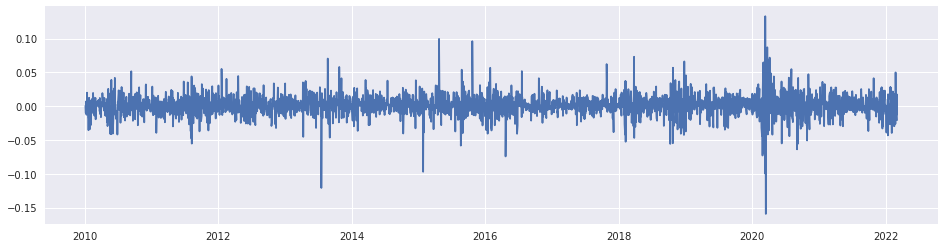

<IPython.core.display.Javascript object>

In [96]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_returns)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   5. adjusted close  3064 non-null   float64
 1   returns            3063 non-null   float64
 2   log_returns        3063 non-null   float64
dtypes: float64(3)
memory usage: 95.8 KB


<IPython.core.display.Javascript object>

In [98]:
X = df[["5. adjusted close"]].values

# df.dropna(inplace=True)
# X = df[["5. adjusted close", "log_returns"]].values


# X = df[["5. adjusted close", "2. high", "3. low", "6. volume", "log_returns"]].values

<IPython.core.display.Javascript object>

In [99]:
from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

In [100]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

<IPython.core.display.Javascript object>

In [101]:
y = [x[0] for x in X_scaled]

<IPython.core.display.Javascript object>

#### Train test split

In [102]:
split = int(len(X_scaled) * 0.9)
print(split)

2757


<IPython.core.display.Javascript object>

In [103]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]

<IPython.core.display.Javascript object>

In [104]:
print(len(X_train))
print(len(X_test))

2757
307


<IPython.core.display.Javascript object>

In [105]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

<IPython.core.display.Javascript object>

#### Labeling

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [106]:
n = 63
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])  # predict next record

<IPython.core.display.Javascript object>

In [107]:
df.head(5)

,5. adjusted close,returns,log_returns
date,,,
2010-01-04,23.857347,NaN,NaN
2010-01-05,23.865055,0.000323,0.000323
2010-01-06,23.718596,-0.006137,-0.006156
2010-01-07,23.473471,-0.010335,-0.010389
2010-01-08,23.633805,0.006830,0.006807


<IPython.core.display.Javascript object>

In [108]:
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]

<IPython.core.display.Javascript object>

In [109]:
scaler.inverse_transform(val)

array([[22.7045227 , 17.89924835]])

<IPython.core.display.Javascript object>

In an LSTM network the input for each LSTM layer needs to contain the following information:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:

(number of observations, number of steps, number of features per step)

In [110]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

<IPython.core.display.Javascript object>

In [111]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(2694, 63, 1)
(2694,)
---
(244, 63, 1)
(244,)


<IPython.core.display.Javascript object>

#### LSTM Model

In [112]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

<IPython.core.display.Javascript object>

In [113]:
results_path = Path('results', 'lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)

<IPython.core.display.Javascript object>

In [114]:
# MAX_EPOCHS = 500
MAX_EPOCHS = 100
# patience=50
patience=30

lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

def compile_and_fit(model, patience=patience):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',  
                                                    restore_best_weights=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.losses.MeanAbsoluteError()])

  history = model.fit(Xtrain, ytrain, epochs=MAX_EPOCHS,
                      validation_data=(Xtest, ytest),
                      callbacks=[early_stopping, checkpointer],
                      batch_size=32,
                      verbose=1)
  return history


<IPython.core.display.Javascript object>

In [115]:
from keras.layers import Dropout

<IPython.core.display.Javascript object>

In [116]:
model = Sequential([
    LSTM(units=64, 
         input_shape=(Xtrain.shape[1], Xtrain.shape[2]), name='LSTM'),
    Dense(1, name='Output')
])

<IPython.core.display.Javascript object>

In [117]:
history = compile_and_fit(model)


Epoch 1/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0181
Epoch 1: val_loss improved from inf to 0.03705, saving model to results/lstm/lstm.h5
85/85 [==============================] - 4s 22ms/step - loss: 0.0013 - mean_absolute_error: 0.0179 - val_loss: 0.0370 - val_mean_absolute_error: 0.1896
Epoch 2/100
82/85 [===========================>..] - ETA: 0s - loss: 2.7794e-04 - mean_absolute_error: 0.0106
Epoch 2: val_loss improved from 0.03705 to 0.00123, saving model to results/lstm/lstm.h5
85/85 [==============================] - 1s 15ms/step - loss: 2.8092e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0012 - val_mean_absolute_error: 0.0294
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 1.8366e-04 - mean_absolute_error: 0.0086
Epoch 3: val_loss did not improve from 0.00123
85/85 [==============================] - 1s 16ms/step - loss: 1.8366e-04 - mean_absolute_error: 0.0086 - val_loss: 0.0055 - val_mean_absolute_err

<IPython.core.display.Javascript object>

In [118]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 64)                16896     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [119]:
train_predict_scaled = model.predict(Xtrain).squeeze()
test_predict_scaled = model.predict(Xtest).squeeze()

print(len(train_predict_scaled))
print(len(test_predict_scaled))

2694
244


<IPython.core.display.Javascript object>

In [120]:
model.evaluate(Xtrain, ytrain)

85/85 [==============================] - 1s 7ms/step - loss: 2.8057e-05 - mean_absolute_error: 0.0031


[2.8056798328179866e-05, 0.0031068192329257727]

<IPython.core.display.Javascript object>

In [121]:
model.evaluate(Xtest, ytest)

8/8 [==============================] - 0s 10ms/step - loss: 1.7323e-04 - mean_absolute_error: 0.0103


[0.00017322771600447595, 0.01029682531952858]

<IPython.core.display.Javascript object>

In [122]:
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [123]:
# calculate mean absolute error
trainScore = mean_absolute_error(ytrain, train_predict_scaled)
print("Train Score: %.4f MAE" % (trainScore))

testScore = mean_absolute_error(ytest, test_predict_scaled)
print("Test Score: %.4f MAE" % (testScore))

Train Score: 0.0031 MAE
Test Score: 0.0100 MAE


<IPython.core.display.Javascript object>

In [124]:
train_predict_rescaled = pd.Series(scaler.inverse_transform(train_predict_scaled.reshape(-1, 1)).squeeze(), index=df.iloc[63:split].index)
test_predict_rescaled = pd.Series(scaler.inverse_transform(test_predict_scaled.reshape(-1, 1)).squeeze(), index=df.iloc[split+63:].index)


<IPython.core.display.Javascript object>

In [125]:
test_predict_rescaled

date
2021-03-18    236.878281
2021-03-19    231.972717
2021-03-22    229.833038
2021-03-23    234.278641
2021-03-24    237.697037
                 ...    
2022-02-28    299.722839
2022-03-01    300.917450
2022-03-02    296.352875
2022-03-03    298.858673
2022-03-04    297.188660
Length: 244, dtype: float32

<IPython.core.display.Javascript object>

In [126]:
df_compare = df.iloc[-244:].copy()

<IPython.core.display.Javascript object>

In [127]:
df_compare["preds"] = test_predict_rescaled

<IPython.core.display.Javascript object>

In [128]:
df_compare

,5. adjusted close,returns,log_returns,preds
date,,,,
2021-03-18,228.854221,-0.026662,-0.027024,236.878281
2021-03-19,228.487213,-0.001604,-0.001605,231.972717
2021-03-22,234.081604,0.024484,0.024190,229.833038
2021-03-23,235.658746,0.006738,0.006715,234.278641
2021-03-24,233.555890,-0.008923,-0.008963,237.697037
...,...,...,...,...
2022-02-28,298.790000,0.004978,0.004966,299.722839
2022-03-01,294.950000,-0.012852,-0.012935,300.917450
2022-03-02,300.190000,0.017766,0.017610,296.352875


<IPython.core.display.Javascript object>

In [129]:
testScore = mean_absolute_error(df_compare["5. adjusted close"].values, df_compare["preds"].values)
print("Test Score: %.4f MAE" % (testScore))

Test Score: 3.2478 MAE


<IPython.core.display.Javascript object>

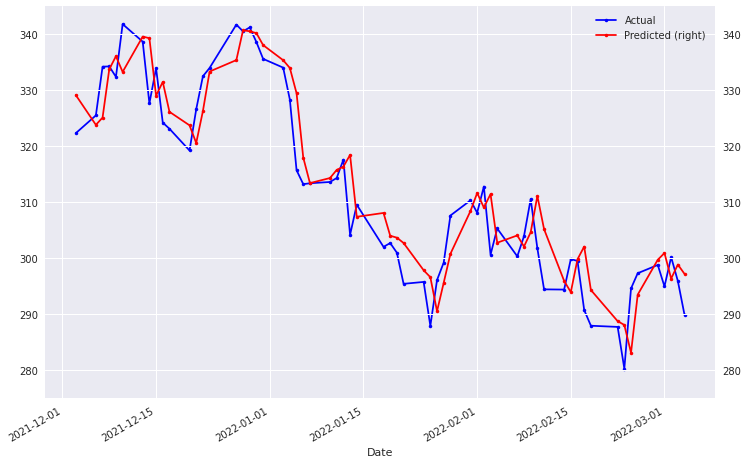

<IPython.core.display.Javascript object>

In [130]:
plt.figure(figsize=(12,8))

ax1 = df_compare["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df_compare["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

a, b = 275, 345

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [131]:
df_compare["actual_percentage_change"] = df_compare['5. adjusted close'].pct_change()
df_compare["actual_increase"] = df_compare["actual_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [132]:
df_compare["predicted_percentage_change"] = df_compare['preds'].pct_change()
df_compare["predicted_increase"] = df_compare["predicted_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [133]:
df_compare.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [134]:
df_compare

,5. adjusted close,returns,log_returns,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
date,,,,,,,,
2021-03-18,228.854221,-0.026662,-0.027024,236.878281,0.000000,0,0.000000,0
2021-03-19,228.487213,-0.001604,-0.001605,231.972717,-0.001604,0,-0.020709,0
2021-03-22,234.081604,0.024484,0.024190,229.833038,0.024484,1,-0.009224,0
2021-03-23,235.658746,0.006738,0.006715,234.278641,0.006738,1,0.019343,1
2021-03-24,233.555890,-0.008923,-0.008963,237.697037,-0.008923,0,0.014591,1
...,...,...,...,...,...,...,...,...
2022-02-28,298.790000,0.004978,0.004966,299.722839,0.004978,1,0.021263,1
2022-03-01,294.950000,-0.012852,-0.012935,300.917450,-0.012852,0,0.003986,1
2022-03-02,300.190000,0.017766,0.017610,296.352875,0.017766,1,-0.015169,0


<IPython.core.display.Javascript object>

In [135]:
df_compare = df_compare.drop("2021-03-18")


<IPython.core.display.Javascript object>

### Postive Increase Prediction %

In [136]:
df_compare[(df_compare["actual_increase"]==1) & (df_compare["predicted_increase"]==1)].shape[0] / df_compare[(df_compare["actual_increase"]==1)].shape[0]

0.5714285714285714

<IPython.core.display.Javascript object>

### Negative Increase Prediction %

In [137]:
df_compare[(df_compare["actual_increase"]==0) & (df_compare["predicted_increase"]==0)].shape[0] / df_compare[(df_compare["actual_increase"]==0)].shape[0]

0.5299145299145299

<IPython.core.display.Javascript object>

### Overall Prediction Accuracy %

In [138]:
df_compare[(df_compare["actual_increase"] == df_compare["predicted_increase"])].shape[0] / (df_compare.shape[0])

0.551440329218107

<IPython.core.display.Javascript object>

### Actual Distribution of Increase (1) vs. Decrease (0)

In [139]:
df_compare["actual_increase"].value_counts(normalize=True)

1    0.518519
0    0.481481
Name: actual_increase, dtype: float64

<IPython.core.display.Javascript object>